# Tuesday Tutorials: Mashup Tutorial

7/11/2020

- Use [contextily](https://github.com/geopandas/contextily) to plot USGS/TNM NHD flowline "overlay" tiles, as I've done in my CSO holovize_test notebook

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import s3fs
import pandas as pd
import geopandas as gpd
import xarray as xr

#from snowmodelzarrfs import connect_fs, get_zarrstore

In [2]:
pd.__version__, gpd.__version__, xr.__version__

('1.0.5', '0.8.0', '0.15.1')

## Read Upper Yakima HUC8

Extract its bounding box, then use it (with a buffer) to query and clip gridded datasets.

In [3]:
wbd_17_hu2_shp_dpth = Path("/home/mayorga/Desktop/2018_NSF_CyberTrainingWater_UWChristina/2020WHW/TuesdayTutorials/data/WBD_17_HU2_Shape")

In [4]:
# huc8_gdf = gpd.read_file(wbd_17_hu2_shp_dpth / "WBDHU8.shp")
# huc8upperyakima_gdf = huc8_gdf[huc8_gdf.huc8 == '17030001']
# huc8upperyakima_gdf.plot()

In [5]:
# huc10upperyakima_gdf = gpd.read_file(wbd_17_hu2_shp_dpth / "WBDHU10.shp", mask=huc8upperyakima_gdf)
huc10_gdf = gpd.read_file(wbd_17_hu2_shp_dpth / "WBDHU10.shp")
len(huc10_gdf)

1679

In [6]:
upyakhuc10_gdf = huc10_gdf[huc10_gdf.huc10.str.startswith('17030001')]
len(upyakhuc10_gdf)

7

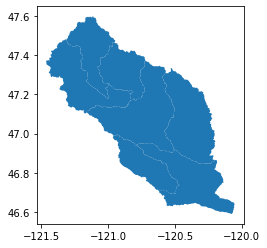

In [7]:
upyakhuc10_gdf.plot();

In [8]:
upyakhuc10_gdf[['huc10', 'name', 'areasqkm']]

,huc10,name,areasqkm
248,1703000102,Middle Fork Teanaway River-Teanaway River,534.67
249,1703000104,Cherry Creek-Wilson Creek,1022.66
250,1703000106,Wenas Creek,496.91
1283,1703000101,Cle Elum River,573.24
1477,1703000103,Kachess River-Yakima River,808.41
1478,1703000105,Taneum Creek-Yakima River,1179.54
1508,1703000107,Umtanum Creek-Yakima River,924.39


In [9]:
upyakhuc10_gdf.total_bounds

array([-121.46606455,   46.59007633, -120.05403042,   47.59780473])

In [10]:
upyakhuc10_gdf.bounds

,minx,miny,maxx,maxy
248,-121.079438,47.167114,-120.721317,47.464477
249,-120.594355,46.844618,-120.197857,47.334252
250,-120.965759,46.691440,-120.467046,46.995461
1283,-121.314362,47.176738,-120.946492,47.597805
1477,-121.466065,47.102206,-120.812732,47.479760
1478,-121.162709,46.901854,-120.501019,47.370253
1508,-120.783258,46.590076,-120.054030,46.951602


## Daymet

THREDDS catalog endpoint for Daymet (aggregated) was recently changed to this:
https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml

OPeNDAP access is available. It looks like you were looking at the netcdf subsetter (ncss). Go to https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html. You'll see that it's split into 3 datasets: continental north america, hawaii and puerto rico. I tested it with the continental north america dataset, https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml. Click on the opendap link to get to the opendap endpoint url, which is https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml. Here's a code snippet that grabs one time step and a region covering Alaska:

Just be careful how much data you request. It's a very large dataset: Dimensions: time: 14600, x: 7814, y: 8075. Also, bear in mind that it's in Lambert Conformal Conic (equal area) projection, not lat-lon.

**Note that the data are in "lambert_conformal_conic", so it'll need to be reprojected to 4326 mash it up with other data.**

In [11]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

In [12]:
daymet_ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

In [13]:
daymet_ds.lambert_conformal_conic

<xarray.DataArray 'lambert_conformal_conic' ()>
array(-32767, dtype=int16)
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    longitude_of_central_meridian:  -100.0
    latitude_of_projection_origin:  42.5
    false_easting:                  0.0
    false_northing:                 0.0
    standard_parallel:              [25. 60.]
    semi_major_axis:                6378137.0
    inverse_flattening:             298.257223563
    longitude_of_prime_meridian:    0.0

In [14]:
daymet_ds.prcp

<xarray.DataArray 'prcp' (time: 14600, y: 8075, x: 7814)>
[921231530000 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4560250.0 -4559250.0 ... 3251750.0 3252750.0
  * y        (y) float32 4984000.0 4983000.0 4982000.0 ... -3089000.0 -3090000.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

In [15]:
testdata_srad = daymet_ds.srad.isel(time=10, x=slice(1000,3000), y=slice(1000,3000))

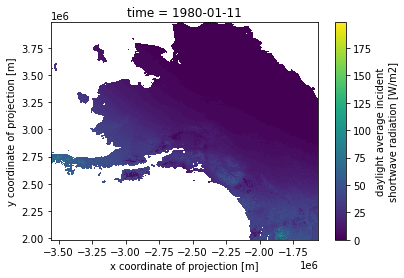

In [16]:
testdata_srad.plot()

## TerraClimate precipitation
TerraClimate, http://www.climatologylab.org/terraclimate.html. Uses CRU. Great for global applications. Has THREDDS server access, http://thredds.northwestknowledge.net:8080/thredds/terraclimate_catalog.html

```python
tcprcp_opendap_url = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc"

tcprcp_ds = xr.open_dataset(tcprcp_opendap_url) # Also tried with decode_cf=False
```

```
OSError: [Errno -45] NetCDF: Not a valid data type or _FillValue type mismatch: b'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc'
```

## GridMet
http://www.climatologylab.org/gridmet.html. Uses PRISM.

```python
gridmetprcp_opendap_url = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_met_pr_1979_CurrentYear_CONUS.nc"

gridmetprcp_ds = xr.open_dataset(gridmetprcp_opendap_url)
```

Produces the same error as with TerraClimate

## PRISM precipitation
https://cida.usgs.gov/thredds/catalog.html?dataset=cida.usgs.gov/prism_v2
Looks like it extends through 2017-12

In [27]:
prism_opendap_url = "https://cida.usgs.gov/thredds/dodsC/prism_v2"

prism_ds = xr.open_dataset(prism_opendap_url)

In [28]:
prism_ds

<xarray.Dataset>
Dimensions:    (lat: 621, lon: 1405, tbnd: 2, time: 1476)
Coordinates:
  * lon        (lon) float32 -125.020836 -124.979164 ... -66.5625 -66.520836
  * lat        (lat) float32 49.9375 49.895832 49.854168 ... 24.145834 24.104166
  * time       (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-12-01
Dimensions without coordinates: tbnd
Data variables:
    time_bnds  (time, tbnd) datetime64[ns] ...
    ppt        (time, lat, lon) float64 ...
    tmx        (time, lat, lon) float32 ...
    tmn        (time, lat, lon) float32 ...
Attributes:
    _NCProperties:             version=1|netcdflibversion=4.4.1|hdf5libversio...
    Conventions:               CF-1.4
    acknowledgment:            PRISM Climate Group, Oregon State University, ...
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Parameter-elevation Regressions on Independent...
    summary:                    This dataset was created using the PRISM (Par...
    keywords:                  Atmospheric Temperature, Air Temperature Atmos...
    keywords_vocabulary:       GCMD Science Keywords
    id:                        prism/thredds/cida.usgs.gov
    naming_authority:          cida.usgs.gov
    cdm_data_type:             Grid
    creator_name:              Christopher Daley
    creator_email:             daley@nacse.org
    publisher_name:            PRISM Climate Group
    publisher_url:             http://prism.oregonstate.edu/
    geospatial_lat_min:        24
    geospatial_lat_max:        53
    geospatial_lon_min:        -125
    geospatial_lon_max:        -67
    time_coverage_start:       1895-01-01T00:00
    time_coverage_end:         2015-12-01T00:00
    time_coverage_resolution:  Monthly
    license:                   Freely Available: The PRISM Climate Group, Ore...
    authors:                   PRISM Climate Group
    institution:               Oregon State University

In [31]:
prism_ds.ppt

<xarray.DataArray 'ppt' (time: 1476, lat: 621, lon: 1405)>
[1287817380 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -125.020836 -124.979164 ... -66.5625 -66.520836
  * lat      (lat) float32 49.9375 49.895832 49.854168 ... 24.145834 24.104166
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-12-01
Attributes:
    units:        mm/month
    long_name:    Mean monthly precipitation
    _ChunkSizes:  [ 1 23 44]

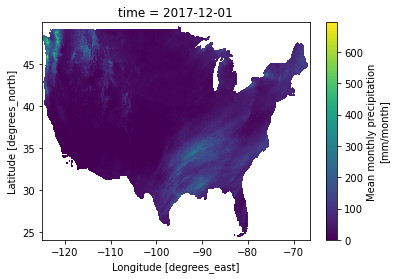

In [30]:
prism_ds.ppt.isel(time=-1).plot()

## SSBo ETa

operational Simplified Surface Energy Balance (SSEBop) model (Senay and others, 2013) for the period 2000 to present
https://cida.usgs.gov/thredds/catalog.html?dataset=cida.usgs.gov/ssebopeta/monthly
See description here: https://cida.usgs.gov/gdp/client/#!catalog/gdp/dataset/54dd5d21e4b08de9379b38b6 and https://earlywarning.usgs.gov/ssebop/modis/daily, https://earlywarning.usgs.gov/docs/USA_DAILYSSEBopETa_Oct2019.pdf

Domain: Conterminous US

In [17]:
ssebop_opendap_url = "https://cida.usgs.gov/thredds/dodsC/ssebopeta/monthly"

ssebop_ds = xr.open_dataset(ssebop_opendap_url)

In [18]:
ssebop_ds

<xarray.Dataset>
Dimensions:  (lat: 2834, lon: 6612, time: 238)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Data variables:
    crs      |S64 ...
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time

In [19]:
ssebop_ds.crs

<xarray.DataArray 'crs' ()>
array(b'', dtype='|S64')
Attributes:
    grid_mapping_name:            latitude_longitude
    long_name:                    CRS definition
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.257223563
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -126 0.008999999999999999 0 49.499999999999...
    _ChunkSizes:                  4096

In [20]:
ssebop_ds.et

<xarray.DataArray 'et' (time: 238, lat: 2834, lon: 6612)>
[4459741104 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Attributes:
    units:         mm
    grid_mapping:  crs
    long_name:     Actual Evapotranspiration
    _ChunkSizes:   [   1 2834 6612]

In [ ]:
ssebop_ds.et.isel(time=-200).plot()